<a href="https://colab.research.google.com/github/ArslanAmanov/AI-ML-DL/blob/default-branch/Kaggle%20Projects%20/UCI%20ML%20drug%20dataset/uci_ml%20drug%20test%20project%20NLP_multiclass%20classific.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
# !pip install torch torchvision

In [3]:
# import torch

# if torch.cuda.is_available():
#     !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
# else:
#     print("No GPU available.")

In [4]:
# import torch
# import torchvision

# print(torch.__version__)
# print(torchvision.__version__)

In [5]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
from functools import partial
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [6]:
#UCI ML drug dataset

#Importing the datasets and libraries
url_1_test='https://raw.githubusercontent.com/ArslanAmanov/AI-ML-DL/default-branch/Kaggle%20Projects%20/UCI%20ML%20drug%20dataset/drugsComTest_raw.csv'
url_2_train='https://raw.githubusercontent.com/ArslanAmanov/AI-ML-DL/default-branch/Kaggle%20Projects%20/UCI%20ML%20drug%20dataset/drugsComTrain_raw.csv'
df1 = pd.read_csv(url_1_test)
df2 = pd.read_csv(url_2_train)

In [7]:
data = pd.concat([df1,df2])[['review','condition']]

In [8]:
data.head()

,review,condition
0,"""I&#039;ve tried a few antidepressants over th...",Depression
1,"""My son has Crohn&#039;s disease and has done ...","Crohn's Disease, Maintenance"
2,"""Quick reduction of symptoms""",Urinary Tract Infection
3,"""Contrave combines drugs that were used for al...",Weight Loss
4,"""I have been on this birth control for one cyc...",Birth Control


In [9]:
#remove Null values from data
data =data[pd.notnull(data['review'])]

# Finding the maxlen

In [10]:
data['len'] = data['review'].apply(lambda a :len(a))

<Axes: ylabel='Frequency'>

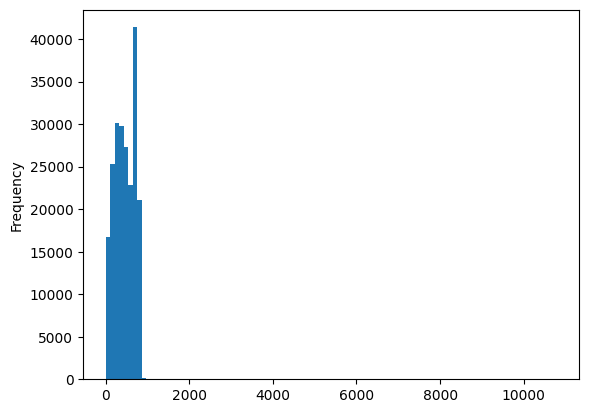

In [11]:
data['len'].plot.hist(bins=100)

In [12]:
data.len.quantile(0.9)

758.0

# Preprocessing Y column
we are only going to be classifying conditions for which the count of reviews are more than 3000

In [13]:
count_df = data[['condition', 'review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review', ascending=False)
count_df.head()

,condition,review
175,Birth Control,38436
273,Depression,12164
613,Pain,8245
133,Anxiety,7812
87,Acne,7435


In [14]:
target_conditions = count_df[count_df['review']>3000]['condition'].values

In [15]:
def condition_parser(x):
  if x in target_conditions:
    return x
  else:
    return "OTHER"
data['condition'] = data['condition'].apply(lambda x: condition_parser(x))

In [16]:
data=data[data['condition']!='OTHER']
import plotly.express as px


In [17]:
px.bar(count_df[count_df['review']>3000], x='condition', y='review')

In [18]:
import re

def clean_text(x):
  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', x)
  return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [19]:
contraction_dict = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
    "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
    "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
    "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
    "mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
    "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
    "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is",
    "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [20]:
# lower the text

data["review"] = data["review"].apply(lambda x:x.lower())

#clean the text
data["review"] = data["review"].apply(lambda x:clean_text(x))

#clean numbers
data["review"] = data["review"].apply(lambda x: clean_numbers(x))

#clean contractions
data["review"] = data["review"].apply(lambda x:replace_contractions(x))

In [21]:
data['condition'].unique()

array(['Depression', 'Weight Loss', 'Birth Control',
       'Vaginal Yeast Infection', 'Insomnia', 'Acne', 'Bipolar Disorde',
       'Diabetes, Type 2', 'Pain', 'Emergency Contraception', 'Anxiety',
       'ADHD', 'Obesity', 'High Blood Pressure'], dtype=object)

In [22]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['review'], data['condition'], stratify=data['condition'], test_size=0.25)

In [23]:
print("Train shape : ", train_X.shape)
print("Test shape : ", test_X.shape)

Train shape :  (83673,)
Test shape :  (27891,)


# Basic Parameters

In [53]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 750  # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5   # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED=10
debug=0

In [25]:
# Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))

train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

##Pad the sentences
train_X = pad_sequences(train_X, maxlen=max_len)
test_X = pad_sequences(test_X, maxlen=max_len)

In [26]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [27]:
le.classes_

array(['ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde', 'Birth Control',
       'Depression', 'Diabetes, Type 2', 'Emergency Contraception',
       'High Blood Pressure', 'Insomnia', 'Obesity', 'Pain',
       'Vaginal Yeast Infection', 'Weight Loss'], dtype=object)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [30]:
# missing entries in the embedding are set using np.random.normal. so we have to seed here too
if debug:
  embedding_matrix= np.random.randn(120000,300)
else:
  embedding_matrix=load_glove(tokenizer.word_index)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [31]:
np.shape(embedding_matrix)

(30972, 300)

#**Pytorch Model - Text CNN**

In [32]:
class CNN_Text(nn.Module):

  def __init__(self):
    super(CNN_Text, self).__init__()
    filter_sizes = [1,2,3,5]
    num_filters = 36
    n_classes = len(le.classes_)
    self.embedding = nn.Embedding(max_features, embed_size)
    self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
    self.embedding.weight.requires_grad = False
    self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
    self.dropout = nn.Dropout(0.1)
    self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


  def forward(self, x):
    x = self.embedding(x)
    x = x.unsqueeze(1)
    x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
    x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
    x = torch.cat(x,1)
    x = self.dropout(x)
    logit = self.fc1(x)
    return logit

# Train TextCNN Model

In [33]:
n_epochs = 6
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch dataset
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
  start_time = time.time()
  # set model to train configuration
  model.train()
  avg_loss = 0.
  for i, (x_batch, y_batch) in enumerate(train_loader):
    # predict/forward pass
    y_pred = model(x_batch)
    # compute loss
    loss = loss_fn(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()/len(train_loader)

    # set model to validation configuration -Doesn't get trained here
    model.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
      y_pred = model(x_batch).detach()
      avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
      # keep/store predictions
      val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()

    #check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y) / len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(epoch + 1, n_epochs,
                                                                                                     avg_loss,
                                                                                                     avg_val_loss,
                                                                                                     val_accuracy,
                                                                                                     elapsed_time))




<ipython-input-33-6dc118c03f6e>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/6 	 loss=8.5117 	 val_loss=1274.4622  	 val_acc=0.3025  	 time=3.83s
Epoch 1/6 	 loss=16.3600 	 val_loss=1195.3939  	 val_acc=0.3446  	 time=6.11s
Epoch 1/6 	 loss=23.7151 	 val_loss=1145.0931  	 val_acc=0.3445  	 time=8.40s
Epoch 1/6 	 loss=30.7143 	 val_loss=1127.6999  	 val_acc=0.3445  	 time=10.68s
Epoch 1/6 	 loss=37.6901 	 val_loss=1128.2077  	 val_acc=0.3445  	 time=12.97s
Epoch 1/6 	 loss=44.7679 	 val_loss=1122.0198  	 val_acc=0.3445  	 time=15.26s
Epoch 1/6 	 loss=51.5149 	 val_loss=1105.6870  	 val_acc=0.3445  	 time=17.54s
Epoch 1/6 	 loss=58.2343 	 val_loss=1084.4965  	 val_acc=0.3445  	 time=19.82s
Epoch 1/6 	 loss=65.1208 	 val_loss=1063.3581  	 val_acc=0.3447  	 time=22.11s
Epoch 1/6 	 loss=71.7608 	 val_loss=1046.4933  	 val_acc=0.3488  	 time=24.40s
Epoch 1/6 	 loss=78.3409 	 val_loss=1034.7884  	 val_acc=0.3749  	 time=26.69s
Epoch 1/6 	 loss=84.8775 	 val_loss=1024.1305  	 val_acc=0.4041  	 time=28.97s
Epoch 1/6 	 loss=91.0033 	 val_loss=1009.7039  	 val_acc

In [34]:
torch.save(model, 'textcnn_model')

In [ ]:
# def plot_graph(num_epochs, train_loss, valid_loss):
#     if len(train_loss) != num_epochs or len(valid_loss) != num_epochs:
#         raise ValueError("Lengths of train_loss and valid_loss should match the number of epochs.")

#     fig = plt.figure(figsize=(12, 12))
#     plt.title("Train/Validation Loss")
#     plt.plot(list(np.arange(num_epochs) + 1), train_loss, label='train')
#     plt.plot(list(np.arange(num_epochs) + 1), valid_loss, label='validation')
#     plt.xlabel('num_epochs', fontsize=12)
#     plt.ylabel('loss', fontsize=12)
#     plt.legend(loc='best')


# plot_graph(n_epochs, train_loss, valid_loss)


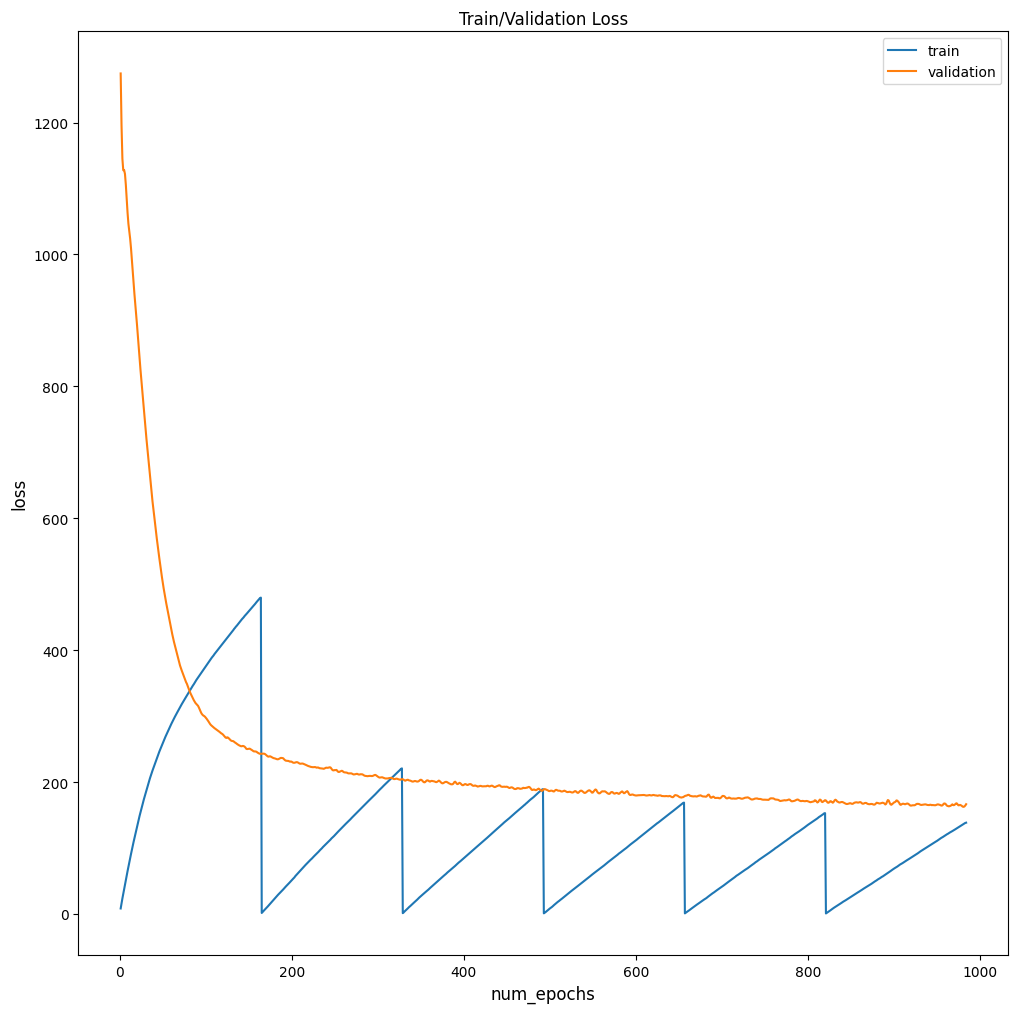

In [35]:
def plot_graph(epochs, train_loss, valid_loss):
    fig = plt.figure(figsize=(12, 12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1), train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

# Example usage:
plot_graph(len(train_loss), train_loss, valid_loss)


In [38]:
# !pip install scikit-plot


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

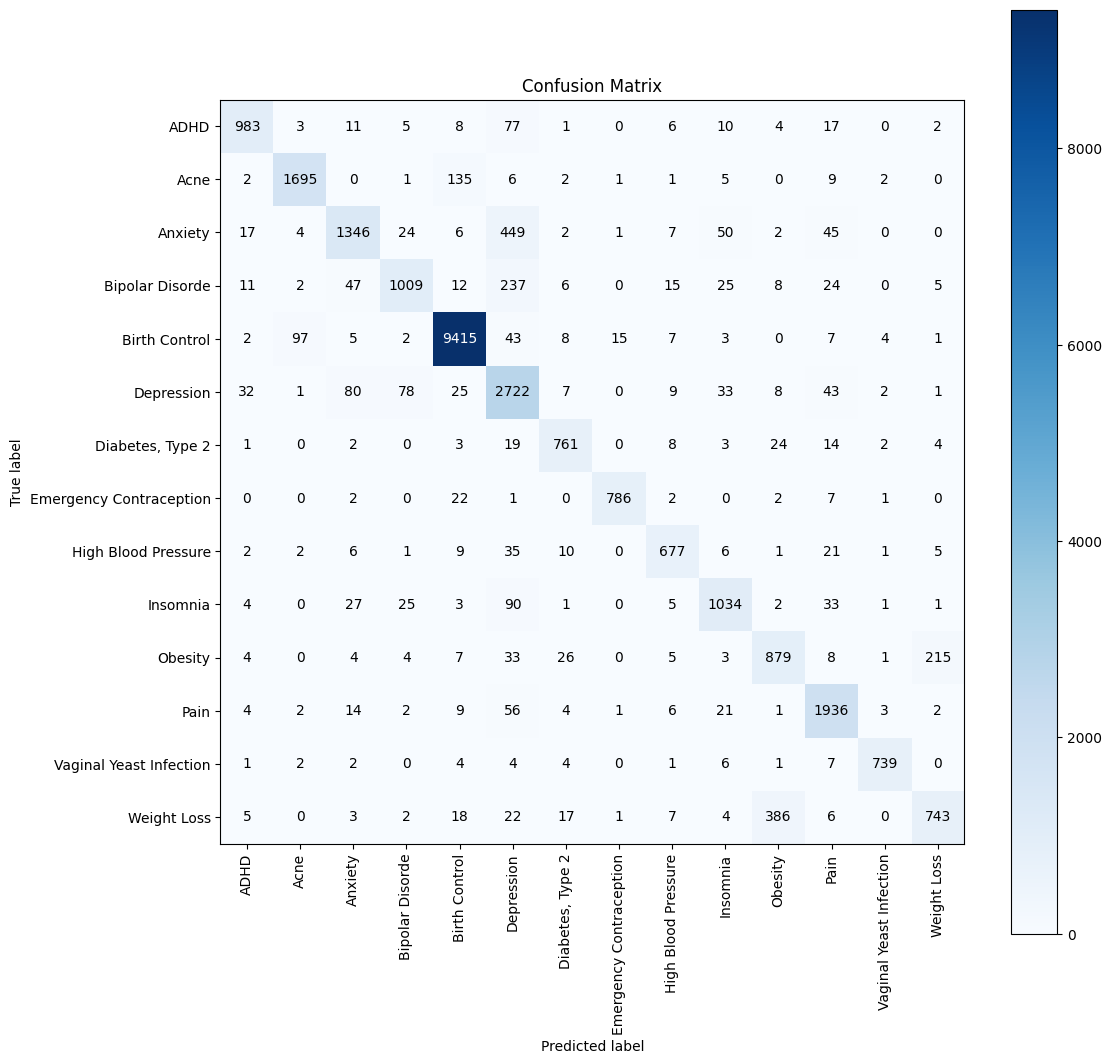

In [39]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true,
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

#Pytorch Model - BiLSTM

In [40]:
class BiLSTM(nn.Module):
  def __init__(self):
    super(BiLSTM, self).__init__()
    self.hidden_size = 64
    drp=0.1
    n_classes = len(le.classes_)
    self.embedding = nn.Embedding(max_features, embed_size)
    self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
    self.embedding.weight.requires_grad = False
    self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first = True)
    self.linear = nn.Linear(self.hidden_size*4, 64)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(drp)
    self.out = nn.Linear(64, n_classes)

  def forward(self, x):
    #rint(x.size())
    h_embedding = self.embedding(x)
    h_lstm, _ = self.lstm(h_embedding)
    avg_pool = torch.mean(h_lstm, 1)
    max_pool, _ = torch.max(h_lstm, 1)
    conc = torch.cat((avg_pool, max_pool), 1)
    conc = self.relu(self.linear(conc))
    conc = self.dropout(conc)
    out = self.out(conc)
    return out

In [45]:
n_epochs = 6
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

    # Set model to validation configuration -Doesn't get trained here
    model.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-45-b3f29a17b96d>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/6 	 loss=864.1377 	 val_loss=476.2384  	 val_acc=0.6746  	 time=10.17s
Epoch 2/6 	 loss=355.0326 	 val_loss=251.6861  	 val_acc=0.8353  	 time=9.93s
Epoch 3/6 	 loss=242.3950 	 val_loss=213.1059  	 val_acc=0.8517  	 time=9.96s
Epoch 4/6 	 loss=209.7850 	 val_loss=197.9753  	 val_acc=0.8605  	 time=9.95s
Epoch 5/6 	 loss=190.4282 	 val_loss=189.2893  	 val_acc=0.8678  	 time=10.29s
Epoch 6/6 	 loss=178.0523 	 val_loss=180.3344  	 val_acc=0.8741  	 time=10.01s


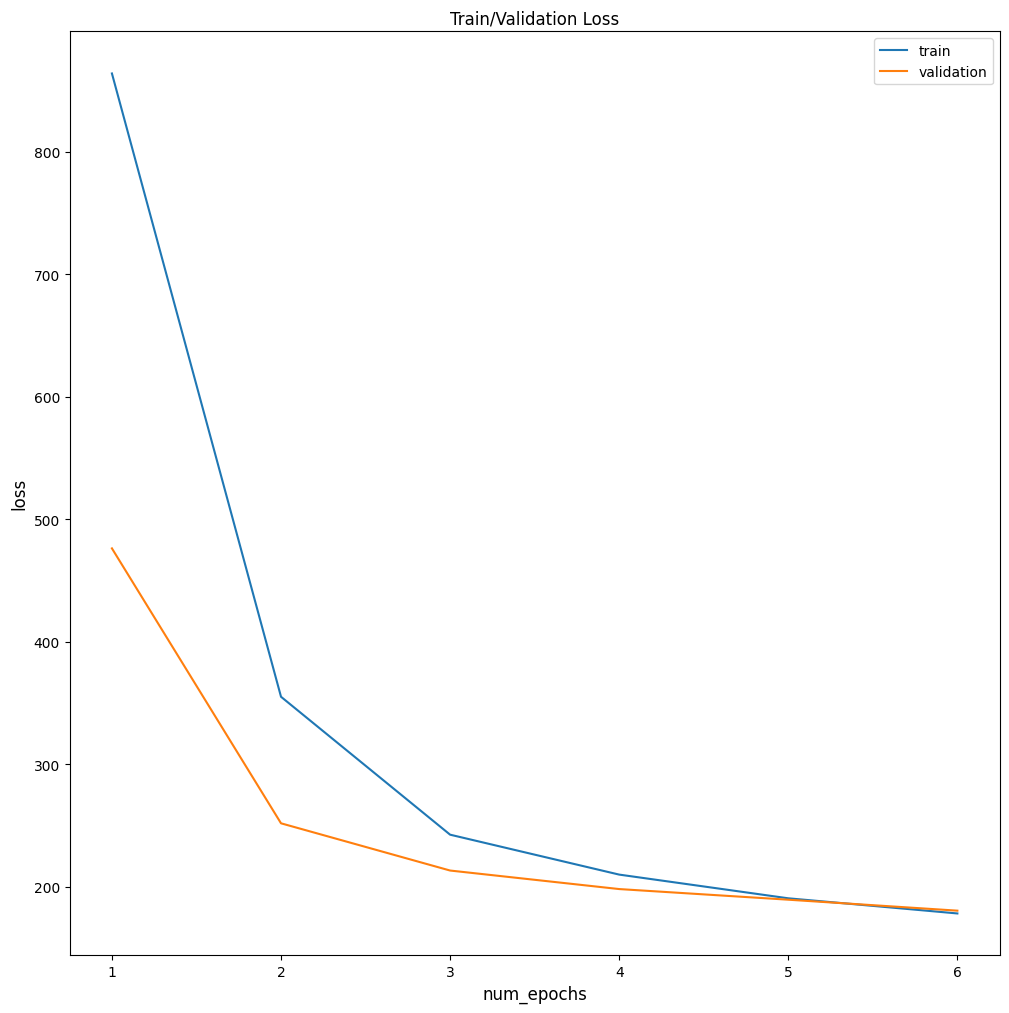

In [47]:
plot_graph(n_epochs, train_loss, valid_loss)

In [48]:
torch.save(model, 'bilstm_model')

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

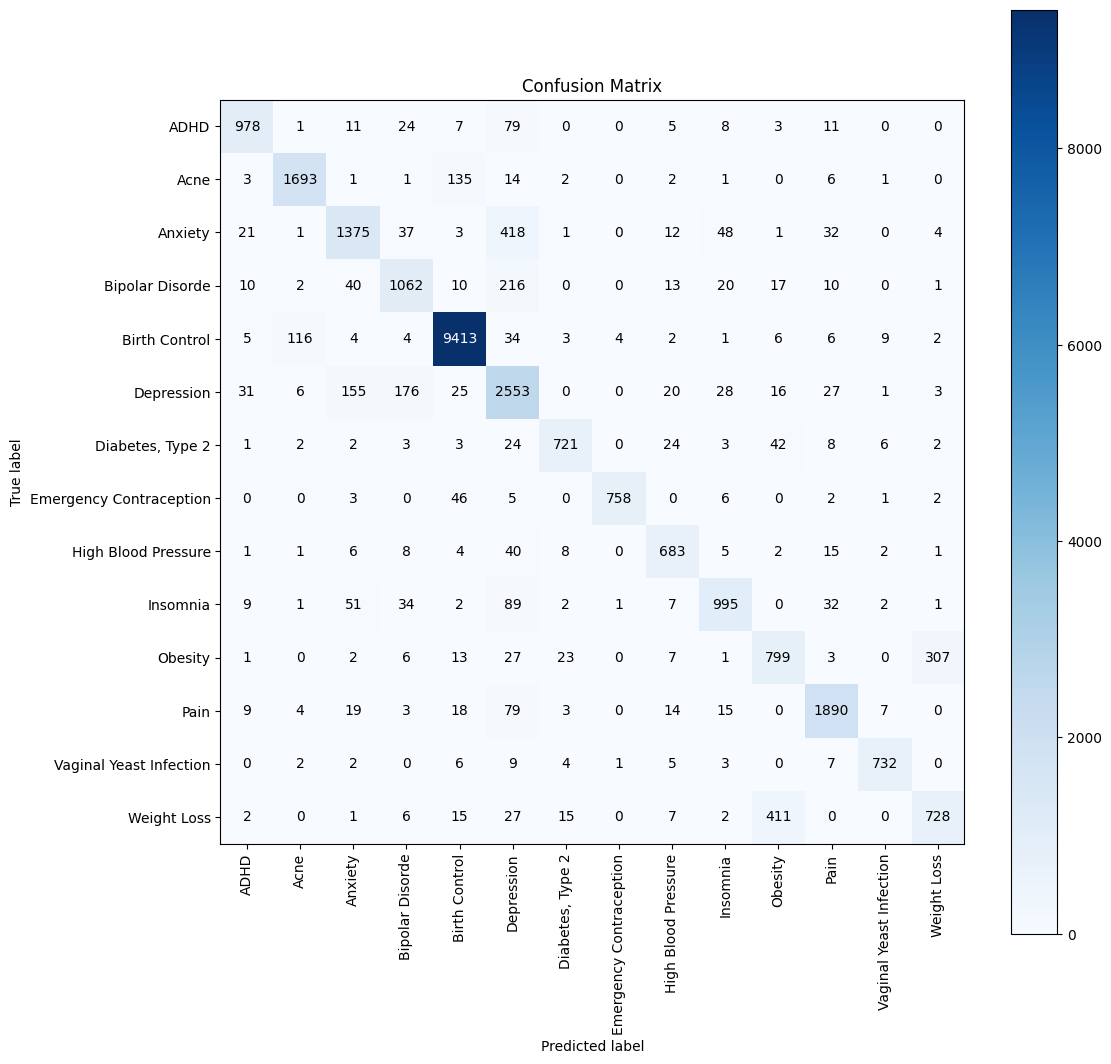

In [49]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true,
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

# Predict single example

In [57]:
def predict_single(x):
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    maxlen=750
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [58]:
x = data['review'].values[20]
print(x)

"i want to share my experience to possibly ease some of the ladies out there.
the incident occur in nov ## (the condom broke) and it was 4 days after my period ended and approximately 4 days before ovulation. this means i was fertile. 
when we noticed that the condom broke, we immediately bought plan b one step and was taken about ## minutes or an hour later. 
the sooner you take the greater the chances it will work.
so i waited anxiously, praying i get my period. i felt side effects such as fatigue, bloated, nauseous, cramps, and moody. i was that these might be  this pregnancy symptoms. 
i waited exactly two weeks and i got my period. i was the happiest person ever. my period was here early by approximately 3-4 days. good luck."


In [59]:
predict_single(x)

<ipython-input-57-de692291538e>:19: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



'Emergency Contraception'

In [60]:
x = data['review'].values[30]
print(x)

"i started off by taking regular ortho tri cyclen, which helped some with my acne, but i also became severely depressed, so i went off it.  after a year and a half of not taking birth control at all, i began taking ortho tri cyclen lo for acne, and after 4 months my skin is much clearer.  if i do get pimples, they are much smaller and more shallow than before, and go away quicker.  i am pleased!"


In [61]:
predict_single(x)

<ipython-input-57-de692291538e>:19: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



'Acne'